In [74]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures , StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [75]:
data = pd.read_csv('../data/voiture_model.csv')
# voir type de données
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   type_vehicule           203 non-null    object 
 1   roues_motrices          203 non-null    object 
 2   modele                  203 non-null    object 
 3   marque                  203 non-null    object 
 4   empattement             203 non-null    float64
 5   longueur_voiture        203 non-null    float64
 6   largeur_voiture         203 non-null    float64
 7   poids_vehicule          203 non-null    float64
 8   taille_moteur           203 non-null    int64  
 9   taux_alésage            203 non-null    float64
 10  chevaux                 203 non-null    int64  
 11  consommation_ville      203 non-null    float64
 12  consommation_autoroute  203 non-null    float64
 13  prix                    203 non-null    float64
dtypes: float64(8), int64(2), object(4)
memory 

In [76]:
# Ajout des nouvelles caractéristiques
# rapport poids puissance en kg/ch
data['rapport_poids_puissance'] = data['poids_vehicule'] / data['chevaux']

# consommation combinée en L/100km 
data['consommation_combinee'] = (data['consommation_ville'] + data['consommation_autoroute']) / 2


# Préparez vos données (séparez les caractéristiques et la cible)
X = data.drop(['prix'], axis=1)
y = data['prix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Identifiez les colonnes numériques et catégorielles
numerical_columns = ['empattement', 'longueur_voiture', 'largeur_voiture', 'poids_vehicule', 'taille_moteur', 'taux_alésage', 'chevaux', 'consommation_ville', 'consommation_autoroute', 'rapport_poids_puissance', 'consommation_combinee']
categorical_columns = ['type_vehicule', 'roues_motrices', 'marque' , 'modele']



## RANDOM FOREST MODEL

In [77]:
# Créer un transformateur pour les variables numériques
num_transformer = Pipeline(steps=[
    ('Normalisation', MinMaxScaler()),
])

# Créer un transformateur pour les variables catégorielles
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Créer un préprocesseur pour combiner les deux transformateurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
    ])

In [78]:
random_forest_params = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2'],
}

In [79]:
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(random_state=42))
])

* Sur un projet de tarification de voitures d'occasion, il peut être important de minimiser les erreurs de prédiction importantes. Dans cette situation, il peut être judicieux d'utiliser le RMSE comme métrique pour évaluer les modèles et choisir le meilleur modèle. Les valeurs d'erreur sont plus importantes que les valeurs moyennes. Par exemple, les erreurs de 10 000 dollars sont plus importantes que les erreurs de 100 dollars.

In [80]:
random_forest_grid = GridSearchCV(random_forest_pipeline, param_grid=random_forest_params, cv=5, scoring='neg_root_mean_squared_error')

In [81]:
random_forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('Normalisation',
                                                                                          MinMaxScaler())]),
                                                                         ['empattement',
                                                                          'longueur_voiture',
                                                                          'largeur_voiture',
                                                                          'poids_vehicule',
                                                                          'taille_moteur',
                                                                          'taux_alésage',
                                                                          'cheva

In [82]:
print("Best parameters for Random Forest:", random_forest_grid.best_params_)
print("Best score for Random Forest:", random_forest_grid.best_score_)

Best parameters for Random Forest: {'random_forest__max_depth': None, 'random_forest__max_features': 'auto', 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 200}
Best score for Random Forest: -2298.737453406803


In [83]:
y_pred_forest_best = random_forest_grid.predict(X_test)

rmse_forest_best = np.sqrt(mean_squared_error(y_test, y_pred_forest_best))

r2_forest_best = r2_score(y_test, y_pred_forest_best)

mae_forest_best = mean_absolute_error(y_test, y_pred_forest_best)


In [84]:
print("\nRandom Forest with best parameters:")
print("RMSE:", rmse_forest_best)
print("R2:", r2_forest_best)
print("MAE:", mae_forest_best)


Random Forest with best parameters:
RMSE: 2234.9830780820657
R2: 0.934548093616057
MAE: 1537.8856035815463


In [85]:
# Identifiez les colonnes numériques et catégorielles
numerical_columns = ['empattement', 'longueur_voiture', 'largeur_voiture', 'poids_vehicule', 'taille_moteur', 'taux_alésage', 'chevaux', 'consommation_ville', 'consommation_autoroute', 'rapport_poids_puissance', 'consommation_combinee']
categorical_columns = ['type_vehicule', 'roues_motrices', 'marque' , 'modele']

# Créer un transformateur pour les variables numériques
num_transformer = Pipeline(steps=[
    ('Normalisation', MinMaxScaler()),
])

# Créer un transformateur pour les variables catégorielles
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Créer un préprocesseur pour combiner les deux transformateurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
    ])

# Créer un pipeline avec le préprocesseur et le modèle
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=None, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100))
])

# Utilise plusieurs random state pour avoir une meilleure idée de la performance du modèle
random_states = [42, 1337, 2020, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 , 10 , 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Créer un DataFrame vide pour stocker les résultats
results_df = pd.DataFrame(columns=['Random State', 'RMSE', 'R2', 'MAE'])

# Utilise plusieurs random state pour avoir une meilleure idée de la performance du modèle
for random_state in random_states:
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Ajuster le modèle avec le pipeline
    model_pipeline.set_params(model__random_state=random_state)
    model_pipeline.fit(X_train_i, y_train_i)
    y_pred_forest_i = model_pipeline.predict(X_test_i)
    
    rmse_forest_i = np.sqrt(mean_squared_error(y_test_i, y_pred_forest_i))
    r2_forest_i = r2_score(y_test_i, y_pred_forest_i)
    mae_forest_i = mean_absolute_error(y_test_i, y_pred_forest_i)
    
    # Ajouter les résultats au DataFrame
    results_df = results_df.append({'Random State': random_state,
                                     'RMSE': rmse_forest_i,
                                     'R2': r2_forest_i,
                                     'MAE': mae_forest_i},
                                    ignore_index=True)

# Afficher le DataFrame des résultats
results_df


/tmp/ipykernel_86655/2894765907.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Random State': random_state,
/tmp/ipykernel_86655/2894765907.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Random State': random_state,
/tmp/ipykernel_86655/2894765907.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Random State': random_state,
/tmp/ipykernel_86655/2894765907.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Random State': random_state,
/tmp/ipykernel_86655/2894765907.py:48: FutureWarning: Th

,Random State,RMSE,R2,MAE
0,42.0,3022.330327,0.880310,1956.321110
1,1337.0,2648.864074,0.919584,1804.208984
2,2020.0,2193.518591,0.882223,1665.531993
3,0.0,3209.202285,0.879963,2009.261944
4,1.0,2541.340656,0.869358,1511.382155
5,2.0,4064.606852,0.703712,2361.516659
6,3.0,2205.849603,0.942126,1626.015711
7,4.0,2297.331595,0.907801,1670.485287
8,5.0,2154.439675,0.934889,1407.634085
9,6.0,1736.838272,0.911854,1328.106992


In [86]:
results_df_best = pd.DataFrame({"Random Forest (Best)": y_pred_forest_best,"Actual": y_test})
results_df_best['Random Forest (Best)'] = results_df_best['Random Forest (Best)'].apply(lambda x: round(x, 3))
results_df_best['Difference'] = results_df_best['Random Forest (Best)'] - results_df_best['Actual']
results_df_best

,Random Forest (Best),Actual,Difference
15,33833.464,30760.000,3073.464
9,18103.822,17859.167,244.655
115,14106.805,16630.000,-2523.195
78,6592.527,6669.000,-76.473
66,11071.224,18344.000,-7272.776
45,7163.851,8916.500,-1752.649
143,10828.121,11259.000,-430.879
177,17877.271,15998.000,1879.271
200,19633.441,21485.000,-1851.559
180,8114.005,7775.000,339.005


### Learning curves

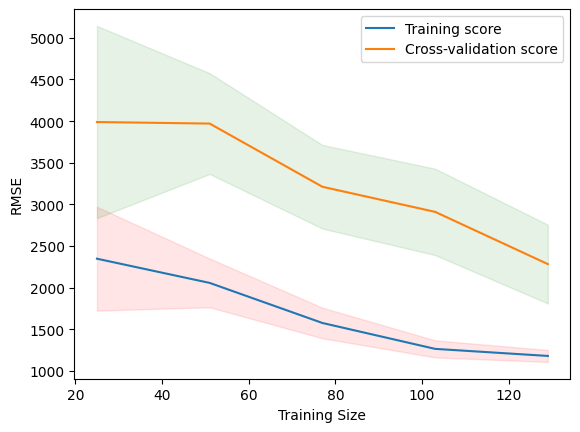

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

best_model = random_forest_grid.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.2, 1.0, 5), cv=5,
    scoring="neg_mean_squared_error",
)

train_scores_rmse = np.sqrt(-train_scores)
test_scores_rmse = np.sqrt(-test_scores)

plt.plot(train_sizes, np.mean(train_scores_rmse, axis=1), label="Training score")
plt.plot(train_sizes, np.mean(test_scores_rmse, axis=1), label="Cross-validation score")

plt.fill_between(train_sizes, np.mean(train_scores_rmse, axis=1) - np.std(train_scores_rmse, axis=1),
                 np.mean(train_scores_rmse, axis=1) + np.std(train_scores_rmse, axis=1), alpha=0.1, color="r")
plt.fill_between(train_sizes, np.mean(test_scores_rmse, axis=1) - np.std(test_scores_rmse, axis=1),
                 np.mean(test_scores_rmse, axis=1) + np.std(test_scores_rmse, axis=1), alpha=0.1, color="g")

plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.show()

In [88]:
for train_size, train_score_mean, train_score_std, test_score_mean, test_score_std in zip(train_sizes, np.mean(train_scores_rmse, axis=1), np.std(train_scores_rmse, axis=1), np.mean(test_scores_rmse, axis=1), np.std(test_scores_rmse, axis=1)):
    print(f"Training Size: {train_size}")
    print(f"Training Score (RMSE) - Mean: {train_score_mean:.2f}, Std: {train_score_std:.2f}")
    print(f"Cross-validation Score (RMSE) - Mean: {test_score_mean:.2f}, Std: {test_score_std:.2f}")
    print()

Training Size: 25
Training Score (RMSE) - Mean: 2348.03, Std: 623.44
Cross-validation Score (RMSE) - Mean: 3989.18, Std: 1153.95

Training Size: 51
Training Score (RMSE) - Mean: 2057.38, Std: 292.63
Cross-validation Score (RMSE) - Mean: 3970.63, Std: 605.03

Training Size: 77
Training Score (RMSE) - Mean: 1576.27, Std: 183.68
Cross-validation Score (RMSE) - Mean: 3211.66, Std: 502.14

Training Size: 103
Training Score (RMSE) - Mean: 1265.37, Std: 102.61
Cross-validation Score (RMSE) - Mean: 2910.38, Std: 518.62

Training Size: 129
Training Score (RMSE) - Mean: 1180.50, Std: 71.83
Cross-validation Score (RMSE) - Mean: 2283.26, Std: 473.10



In [89]:
data

,type_vehicule,roues_motrices,modele,marque,empattement,longueur_voiture,largeur_voiture,poids_vehicule,taille_moteur,taux_alésage,chevaux,consommation_ville,consommation_autoroute,prix,rapport_poids_puissance,consommation_combinee
0,cabriolet,propulsion,GIULIA,ALFA-ROMEO,225.0,428.8,162.8,1155.752416,130,88.1,111,11.20,8.71,13495.0,10.412184,9.955
1,cabriolet,propulsion,STELVIO,ALFA-ROMEO,225.0,428.8,162.8,1155.752416,130,88.1,111,11.20,8.71,16500.0,10.412184,9.955
2,hayon,propulsion,QUADRIFOGLIO,ALFA-ROMEO,240.0,434.8,166.4,1280.490216,152,68.1,154,12.38,9.05,16500.0,8.314872,10.715
3,berline,traction,100LS,AUDI,253.5,448.6,168.1,1060.044504,109,81.0,102,9.80,7.84,13950.0,10.392593,8.820
4,berline,quatre_roues_motrices,100LS,AUDI,252.5,448.6,168.7,1280.943808,136,81.0,115,13.07,10.69,17450.0,11.138642,11.880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,berline,propulsion,145E SW,VOLVO,277.1,479.6,175.0,1339.003584,141,96.0,114,10.23,8.40,16845.0,11.745645,9.315
199,berline,propulsion,144EA,VOLVO,277.1,479.6,174.8,1383.002008,141,96.0,160,12.38,9.41,19045.0,8.643763,10.895
200,berline,propulsion,244 DL,VOLVO,277.1,479.6,175.0,1366.219104,173,90.9,134,13.07,10.23,21485.0,10.195665,11.650
201,berline,propulsion,246,VOLVO,277.1,479.6,175.0,1459.205464,145,76.5,106,9.05,8.71,22470.0,13.766089,8.880


In [90]:
import pickle

# Enregistrer le modèle dans un fichier pickle
with open('../models/random_forest.pkl', 'wb') as file:
    pickle.dump(random_forest_grid, file)

In [91]:
X_test

,type_vehicule,roues_motrices,modele,marque,empattement,longueur_voiture,largeur_voiture,poids_vehicule,taille_moteur,taux_alésage,chevaux,consommation_ville,consommation_autoroute,rapport_poids_puissance,consommation_combinee
15,berline,propulsion,X4,BMW,262.9,480.1,169.9,1465.102160,209,91.9,182,14.70,10.69,8.050012,12.695
9,hayon,quatre_roues_motrices,5000S DIESEL,AUDI,252.7,452.6,172.5,1384.816376,131,79.5,160,14.70,10.69,8.655102,12.695
115,berline,propulsion,504,PEUGEOT,274.1,474.2,173.7,1394.795400,120,87.9,97,12.38,9.80,14.379334,11.090
78,hayon,traction,OUTLANDER,MITSUBISHI,238.0,399.5,163.6,908.998368,92,75.4,68,7.59,6.19,13.367623,6.890
66,berline,propulsion,RX-7GS,MAZDA,266.4,444.5,167.9,1224.698400,134,87.1,72,7.59,6.03,17.009700,6.810
45,berline,traction,D-MAX V-CROSS,ISUZU,240.0,396.0,161.5,865.907128,90,77.0,70,6.19,5.47,12.370102,5.830
143,berline,quatre_roues_motrices,R2,SUBARU,246.4,436.9,166.1,1138.515920,108,91.9,111,9.80,8.11,10.256900,8.955
177,hayon,propulsion,CORONA,TOYOTA,261.4,466.1,172.0,1368.033472,171,83.1,161,12.38,9.80,8.497102,11.090
200,berline,propulsion,244 DL,VOLVO,277.1,479.6,175.0,1366.219104,173,90.9,134,13.07,10.23,10.195665,11.650
180,berline,traction,RABBIT,VOLKSWAGEN,247.1,436.1,166.4,1025.571512,97,76.5,52,6.36,5.11,19.722529,5.735


In [92]:
data['modele'].value_counts()

504         6
COROLLA     6
CORONA      6
DL          4
CIVIC       3
           ..
GLC4        1
RX2COUPE    1
RX3         1
XK          1
246         1
Name: modele, Length: 140, dtype: int64

In [93]:
# va chercher le modèle 504 et montre moi ses résultats data
data[data['modele'] == "COROLLA"]

,type_vehicule,roues_motrices,modele,marque,empattement,longueur_voiture,largeur_voiture,poids_vehicule,taille_moteur,taux_alésage,chevaux,consommation_ville,consommation_autoroute,prix,rapport_poids_puissance,consommation_combinee
157,hayon,traction,COROLLA,TOYOTA,243.1,422.4,163.6,1031.921800,110,83.1,56,6.19,5.00,7788.0,18.427175,5.595
159,hayon,traction,COROLLA,TOYOTA,243.1,422.4,163.6,962.522224,98,81.0,70,8.40,6.92,8358.0,13.750317,7.660
166,coupé fermé,propulsion,COROLLA,TOYOTA,249.9,447.5,166.6,1150.309312,146,91.9,116,9.80,7.84,9639.0,9.916460,8.820
169,hayon,propulsion,COROLLA,TOYOTA,249.9,447.5,166.6,1231.048688,146,91.9,116,9.80,7.84,11549.0,10.612489,8.820
171,berline,traction,COROLLA,TOYOTA,260.1,446.0,168.9,1055.054992,122,84.1,92,8.11,6.92,8948.0,11.467989,7.515
174,berline,traction,COROLLA,TOYOTA,260.1,446.0,168.9,1094.971088,122,84.1,92,8.71,7.35,10898.0,11.901860,8.030
